# MERFISH whole brain spatial transcriptomics (part 2b)

We can continue to explore our examples looking at the expression of canonical neurotransmitter transporter genes and gene Tac2 over the whole brain.

You need to be connected to the internet to run this notebook and that you have downloaded the example data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import requests
import seaborn as sns
import pathlib
%matplotlib inline

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20230830'
download_base = '/alzheimer/Roberto/Allen_Institute/abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)
    
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['MERFISH-C57BL6J-638850']['directories']['metadata']['relative_path'], 
                              'views')
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

Read in the expanded cell metadata table we created in part 1.

In [4]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file,dtype={"cell_label":str,"neurotransmitter":str})
cell.set_index('cell_label',inplace=True)

In [5]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['MERFISH-C57BL6J-638850-CCF']['directories']['metadata']['relative_path'], 
                              'views')
view_directory = pathlib.Path( view_directory )
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file,dtype={"cell_label":str})
cell.rename(columns={'x':'x_section','y':'y_section','z':'z_section'},inplace=True)
cell.set_index('cell_label',inplace=True)


metadata = manifest['file_listing']['MERFISH-C57BL6J-638850-CCF']['metadata']
rpath = metadata['reconstructed_coordinates']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
reconstructed_coords = pd.read_csv(file,dtype={"cell_label":str})
reconstructed_coords.rename(columns={'x':'x_reconstructed','y':'y_reconstructed','z':'z_reconstructed'},inplace=True)
reconstructed_coords.set_index('cell_label',inplace=True)
cell = cell.join(reconstructed_coords,how='inner')


In [6]:
cell.columns

Index(['brain_section_label', 'cluster_alias', 'average_correlation_score',
       'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex',
       'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class',
       'subclass', 'supertype', 'cluster', 'neurotransmitter_color',
       'class_color', 'subclass_color', 'supertype_color', 'cluster_color',
       'x_reconstructed', 'y_reconstructed', 'z_reconstructed',
       'parcellation_index'],
      dtype='object')

In [7]:
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
exp = pd.read_csv(file,dtype={"cell_label":str})
exp.set_index('cell_label',inplace=True)

In [124]:
htrgenes = np.sort(exp.columns)

In [8]:
metadata = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
parcellation_annotation.head(5)

,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure
parcellation_index,,,,,
0,unassigned,unassigned,unassigned,unassigned,unassigned
1,brain,grey,HY,TMv,TMv
2,brain,grey,Isocortex,SSp-m,SSp-m6b
5,brain,fiber tracts,lfbs,cst,int
6,brain,grey,P,PSV,PSV


In [9]:
rpath = metadata['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]
parcellation_color.head(5)

,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
parcellation_index,,,,,
0,#000000,#000000,#000000,#000000,#000000
1,#FFFFFF,#BFDAE3,#E64438,#FF4C3E,#FF4C3E
2,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064
5,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
6,#FFFFFF,#BFDAE3,#FF9B88,#FFAE6F,#FFAE6F


In [10]:
cell = cell.join(parcellation_annotation,on='parcellation_index')
cell = cell.join(parcellation_color,on='parcellation_index')
cell.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,...,brain,grey,HPF,DG,DG-po,#FFFFFF,#BFDAE3,#7ED04B,#7ED04B,#7ED04B
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,...,brain,grey,P,TRN,TRN,#FFFFFF,#BFDAE3,#FF9B88,#FFBA86,#FFBA86
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,...,brain,fiber tracts,cbf,arb,arb,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88


Read in the gene expression dataframe we created in part 2a.

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory.

In [11]:
def aggregate_by_metadata( df, gnames, value, sort=False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of expression of the 9 solute carrier family genes for all the cells in the dataset.  We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group and visualized as a colorized table.

The results are similar that in part 1. Using data from the whole brain, gene Slc17a7 is now most enriched in glutamatergic assigned cells. Gene Slc17a6 is most enriched in noradrenergic, then cholinergic types. Genes Slc6a5, Slc6a3 and Slc6a4 shows high specificity to glycinergic, dopaminergic, serotonergic respectively.

In [12]:
def plot_heatmap( df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmin=0, vmax=5) :

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap = cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels( xlabs )

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels( ylabs )

We define a small helper function *plot sections* to visualize the cells for a specified set of brain sections either by colorized metadata or gene expression.

In [13]:
def plot_sections( df, feature, blist, cmap=None, fig_width = 20, fig_height = 5, vmin=0, vmax=10) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist) :
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x_reconstructed']
        yy = filtered['y_reconstructed']
        vv = filtered[feature]
        
        if cmap is not None :
            ax[idx].scatter(xx,yy,s=1.0,c=vv,marker='.',cmap=cmap)
        else :
            ax[idx].scatter(xx,yy,s=1.0,color=vv,marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0,11)
        ax[idx].set_ylim(11,0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s" % (bsl) )
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax
    

In [14]:
def plot_section_CCF(  xx=None, yy=None, cc=None, val=None, pcmap=None, 
                 overlay=None, extent=None, bcmap=plt.cm.Greys_r, alpha=1.0,s=.5,
                 fig_width = 6, fig_height = 6, fig=None, ax=None ) :
    
    if ax is None:
        fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)


    
    if xx is not None and yy is not None and pcmap is not None :
        ax.scatter(xx,yy,s=s,c=val,marker='.',cmap=pcmap, alpha=alpha)
    elif xx is not None and yy is not None and cc is not None :
        ax.scatter(xx,yy,s=s,color=cc,marker='.',zorder=1, alpha=alpha)   
        
    if overlay is not None and extent is not None and bcmap is not None :
        plt.imshow(overlay, cmap=bcmap, extent=extent,alpha=alpha,zorder=2)
        
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

We will use the aggregate by brain section table above to pick a four sections of interest and plot cells in those sections by neurotransmitter type and by each of the transporter genes.

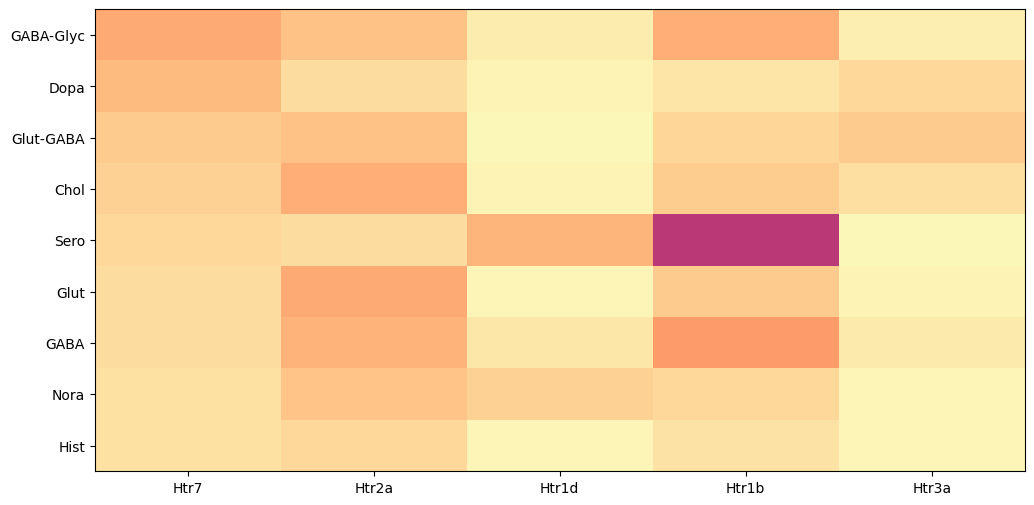

In [15]:
exgenes = exp.columns
filtered = exp[exgenes]
joined = cell.join(filtered)
joined_bool = cell.join(exp.astype("bool"))
agg = aggregate_by_metadata( joined, exgenes, 'neurotransmitter', True )
plot_heatmap(agg,12,6)

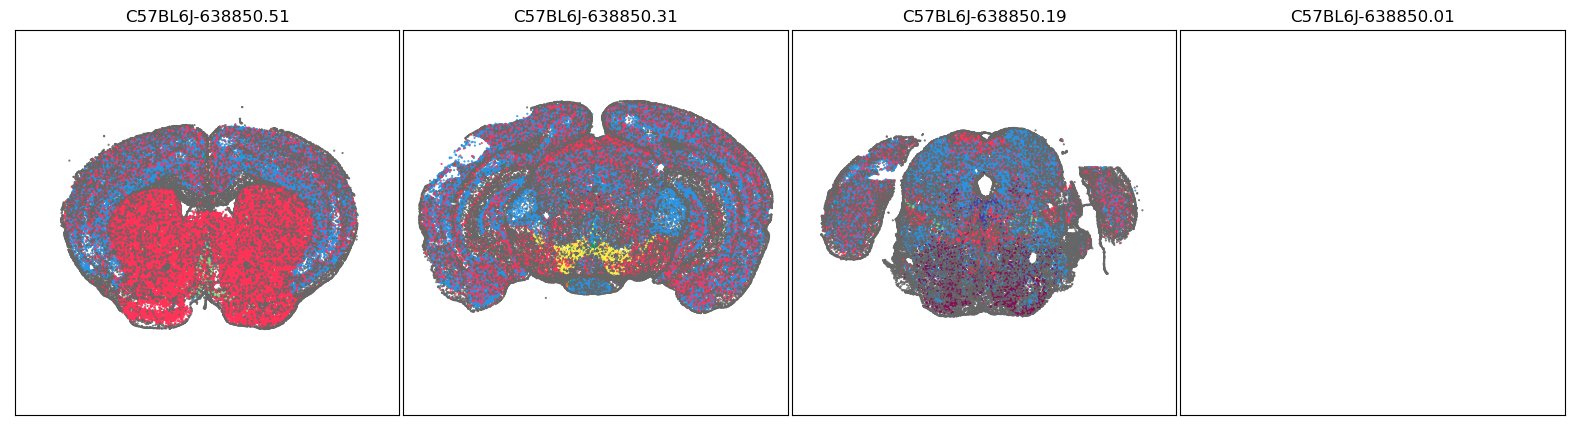

In [16]:
blist = ['C57BL6J-638850.51','C57BL6J-638850.31','C57BL6J-638850.19','C57BL6J-638850.01']
fig, ax = plot_sections( joined, 'neurotransmitter_color', blist, cmap=None)

### Expression of Tachykinin 2 (Tac2) in the whole brain

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

In this example, we create a dataframe comprising expression values of Tac2 for all cells across the whole brain. As with the single brain section example, grouping expression by neurotransmitter show that Tac2 gene is enriched in cholinergic cell types. With the rest of brain included, we can observe that Tac2 is also enriched in Glut-GABA cell types as well.

In [17]:
exp[exp<1]

,Htr7,Htr2a,Htr1d,Htr1b,Htr3a
cell_label,,,,,
1015221640100570419,NaN,NaN,NaN,0.000000,0.000000
1015221640100590598,0.000000,0.0,0.0,NaN,0.000000
1015221640100820600,0.708079,0.0,0.0,NaN,0.708079
1015221640100580476,0.000000,NaN,0.0,0.000000,0.000000
1015221640100580189,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...
1018145707100250222,0.000000,0.0,0.0,0.000000,0.936483
1018145707100250185,0.000000,0.0,0.0,0.000000,0.000000
1018145707100430302,0.000000,0.0,0.0,0.000000,0.000000


<AxesSubplot:>

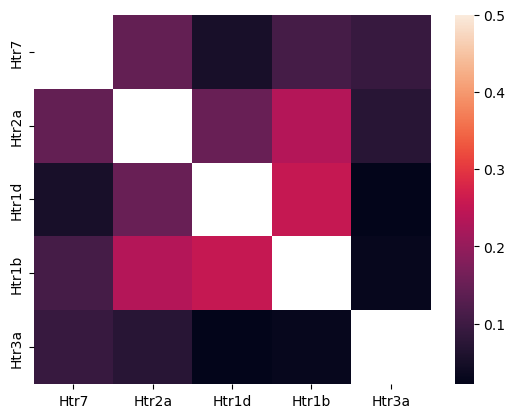

In [18]:
_ = exp.corr()
sns.heatmap(_[_<1], vmax=.5)

In [19]:
agg

,Htr7,Htr2a,Htr1d,Htr1b,Htr3a
neurotransmitter,,,,,
GABA-Glyc,0.892042,0.626116,0.181505,0.855613,0.159068
Dopa,0.714702,0.347214,0.109533,0.257989,0.394156
Glut-GABA,0.535751,0.632136,0.077714,0.428327,0.542141
Chol,0.477986,0.843158,0.098220,0.519922,0.317686
Sero,0.397254,0.340483,0.763565,2.428210,0.074240
Glut,0.347664,0.894821,0.086077,0.543314,0.099446
GABA,0.341766,0.794740,0.249244,1.043829,0.206541
Nora,0.304132,0.624830,0.484660,0.396208,0.088780
Hist,0.303713,0.398378,0.079964,0.286993,0.096093


Grouping by class, shows that Tac2 is enriched in class "16 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic type and "06 CTX-CGE GABA" GABAergic cells originating from the caudal ganglionic eminence (CGE).

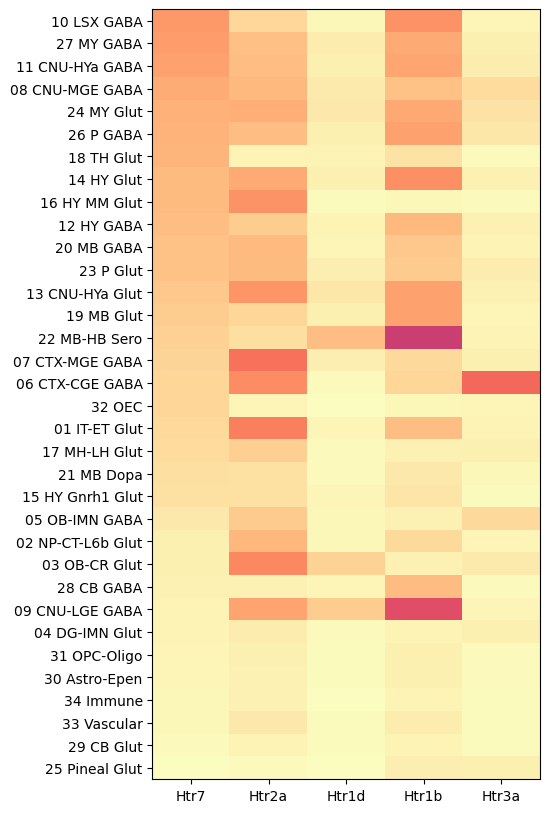

In [20]:
agg = aggregate_by_metadata( joined, exgenes, 'class', True )
class_list = agg.index[0:2]
plot_heatmap(agg,5,10)

At the next level, grouping by subclass reveals enrichment is highly anatomically localized cell types such as the medial habenula (MH), bed nuclei of the stria terminalis (BST), spinal nucleus of the trigeminal (SPVC), main olfactory blub (MOB), central amygdalar nucleus (CEA) and arcuate hypothalamic nucleus (ARH).

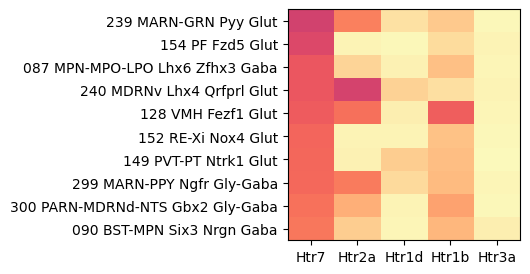

In [21]:
agg = aggregate_by_metadata( joined, exgenes, 'subclass', True ).head(10)
subclass_list = agg.index[0:10]
plot_heatmap(agg,3,3)

In [22]:
aggregate_by_metadata( joined, exgenes, 'cluster', True ).quantile(.9)

Htr7     1.405805
Htr2a    1.566649
Htr1d    0.289197
Htr1b    1.797392
Htr3a    0.344277
Name: 0.9, dtype: float64

In [23]:
level = "cluster"
all = aggregate_by_metadata( joined, exgenes, level, True )

In [24]:
all

,Htr7,Htr2a,Htr1d,Htr1b,Htr3a
cluster,,,,,
4101 PCG-PRNr Vsx2 Nkx6-1 Glut_1,2.794541,0.156260,0.206277,0.209368,0.174179
1260 MEA-BST Lhx6 Sp9 Gaba_5,2.773751,0.937776,0.129664,0.462201,0.088848
2713 PF Fzd5 Glut_1,2.694119,0.172294,0.101472,0.447646,0.079757
2702 RE-Xi Nox4 Glut_3,2.680445,0.254102,0.129936,1.860854,0.080921
4302 NTS Phox2b Glut_10,2.634803,0.245334,0.025603,0.893719,0.066446
...,...,...,...,...,...
2232 MPN-MPO-PVpo Hmx2 Glut_1,0.000000,2.768684,0.000000,1.242395,0.172534
2120 ADP-MPO Trp73 Glut_1,0.000000,1.721134,0.000000,2.182142,0.000000
5080 NTS-PARN Neurod2 Gly-Gaba_1,0.000000,0.000000,0.000000,0.417457,0.000000


In [25]:
labels = all.index.to_series().str.extract(r' ([a-zA-Z\-]+)_')[0]
# Build regex pattern for extraction
pattern = r'(?i)(' + '|'.join(labels) + ')'

all["neurotransmitter"] = all.index.to_series().str.extract(pattern)[0]
all["Neuron type"] = all.index.to_series().str.extract(r'(Pv|Sst|Vip|Glut)')

1.4058046352106828

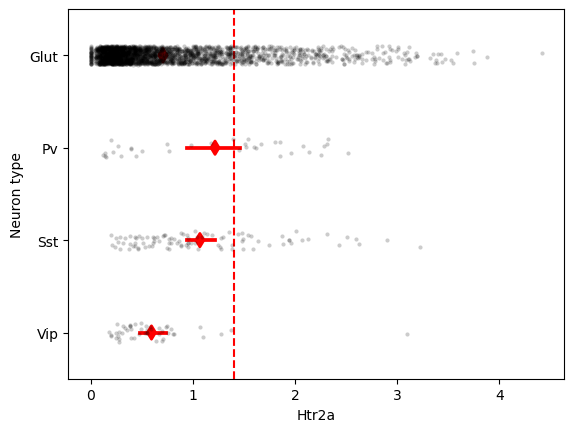

In [26]:
order= ["Glut", "Pv", "Sst", "Vip"] 
sns.stripplot(data=all, x="Htr2a", y="Neuron type", color="k", alpha=.2, order=order, s=3)
sns.pointplot(data=all, x="Htr2a", y="Neuron type", join=False, dodge=.2,
    markers="d", order=order, color="r" )
plt.axvline(x=aggregate_by_metadata(joined, exgenes, level, True ).quantile(.9)[0], color='r', linestyle='--')
aggregate_by_metadata( joined, exgenes, level, True ).quantile(.9)[0]

<AxesSubplot:xlabel='Htr2a', ylabel='Neuron type'>

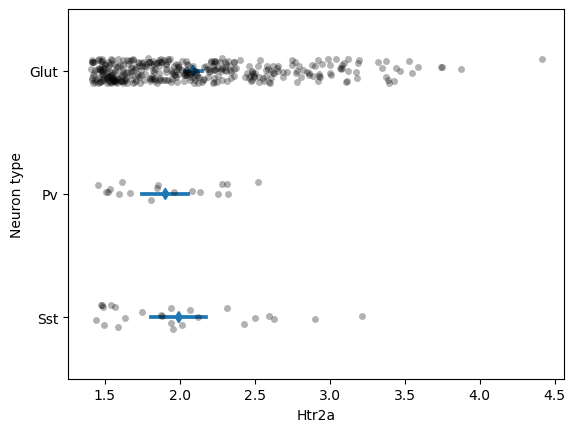

In [27]:
order= ["Glut", "Pv", "Sst"] 
top_all = all[all["Htr2a"]>aggregate_by_metadata( joined, exgenes, level, True ).quantile(.9)[0]]
sns.stripplot(data=top_all, x="Htr2a", y="Neuron type", color="k", alpha=.3 , order=order)
sns.pointplot(data=top_all, x="Htr2a", y="Neuron type", join=False, order=order, dodge=.8 - .8 / 3,
    markers="d", scale=.75)

In [28]:
top_all[top_all["Neuron type"]=="Sst"]

,Htr7,Htr2a,Htr1d,Htr1b,Htr3a,neurotransmitter,Neuron type
cluster,,,,,,,
0828 Sst Gaba_19,1.495970,2.898836,0.097195,0.298851,0.123103,Gaba,Sst
0789 Sst Gaba_6,1.163562,1.633315,0.078823,0.232996,0.238602,Gaba,Sst
0825 Sst Gaba_18,1.135036,1.566587,0.214016,0.249489,0.151860,Gaba,Sst
0817 Sst Gaba_15,1.132823,1.940941,0.086331,0.243965,0.107922,Gaba,Sst
0763 Sst Gaba_2,1.103649,1.438729,0.486192,0.619515,0.238691,Gaba,Sst
0823 Sst Gaba_17,1.000625,2.314557,0.610412,0.243795,0.133822,Gaba,Sst
0827 Sst Gaba_19,0.966812,1.939689,0.060695,1.197881,0.106095,Gaba,Sst
0826 Sst Gaba_18,0.964403,1.587048,0.274357,0.186463,0.125206,Gaba,Sst
0766 Sst Gaba_2,0.796306,1.747954,0.213871,0.289236,0.197716,Gaba,Sst


<AxesSubplot:ylabel='count'>

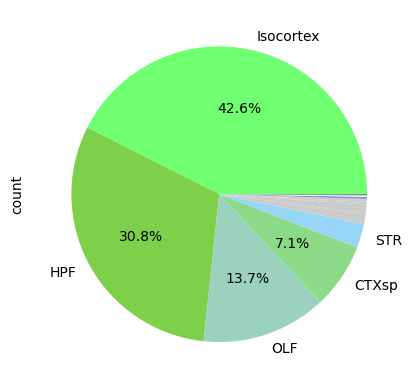

In [29]:
color_map = dict(zip(cell["parcellation_division"], cell["parcellation_division_color"].apply(plt_colors.to_rgba)))

# Custom function for autopct
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues))
    if pct < 3: 
        return ""
    else:
        return "{:.1f}%".format(pct, absolute)

labels = cell[cell["cluster"].isin(top_all[top_all["Neuron type"]=="Sst"].index)]["parcellation_division"].value_counts()

total = labels.sum()
percentages = labels / total * 100

labels_renamed = labels.copy()
# Replace labels with a percentage less than 1% to ''
labels_renamed.index = [index if percent >= 2 else '' for index, percent in percentages.items()]

labels_renamed.plot(kind='pie', autopct=lambda pct: func(pct, cell["parcellation_division"].value_counts()), colors=[color_map[key] for key in labels.index])

<AxesSubplot:ylabel='count'>

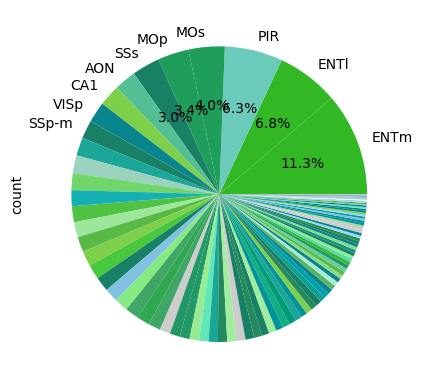

In [30]:
color_map = dict(zip(cell["parcellation_structure"], cell["parcellation_structure_color"].apply(plt_colors.to_rgba)))

# Custom function for autopct
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues))
    if pct < 3: 
        return ""
    else:
        return "{:.1f}%".format(pct, absolute)

labels = cell[cell["cluster"].isin(top_all[top_all["Neuron type"]=="Sst"].index)]["parcellation_structure"].value_counts()

total = labels.sum()
percentages = labels / total * 100

labels_renamed = labels.copy()
# Replace labels with a percentage less than 1% to ''
labels_renamed.index = [index if percent >= 2 else '' for index, percent in percentages.items()]

labels_renamed.plot(kind='pie', autopct=lambda pct: func(pct, cell["parcellation_structure"].value_counts()), colors=[color_map[key] for key in labels.index])

In [31]:
labels_renamed

ENTm    1105
ENTl     668
PIR      622
MOs      388
MOp      335
        ... 
           1
           1
           1
           1
           1
Name: count, Length: 100, dtype: int64

<AxesSubplot:>

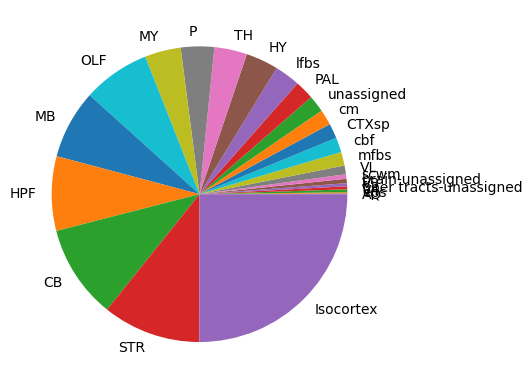

In [32]:
joined.groupby('parcellation_division').size().sort_values().plot.pie()

In [33]:
joined[joined["parcellation_division"]=="Isocortex"].groupby('parcellation_structure')["Htr2a"].mean().sort_values(ascending=False)

parcellation_structure
ORBl       1.551023
AId        1.527792
GU         1.438306
MOs        1.389232
MOp        1.334392
AIv        1.329367
ORBvl      1.321158
FRP        1.319576
SSs        1.189923
SSp-ll     1.185141
SSp-tr     1.158492
VISC       1.143985
ACAd       1.130834
PL         1.071044
SSp-ul     1.063027
VISrl      1.053516
AIp        1.047271
AUDd       1.021604
ORBm       1.012403
SSp-un     1.009280
SSp-m      1.007684
AUDv       1.002287
ACAv       0.982956
VISa       0.933364
VISli      0.922479
SSp-bfd    0.920940
TEa        0.903579
SSp-n      0.880734
ECT        0.852792
VISl       0.820541
AUDp       0.801002
AUDpo      0.799135
PERI       0.786894
VISal      0.784692
VISam      0.739884
VISpm      0.714604
RSPagl     0.714414
VISpor     0.707775
VISp       0.701223
ILA        0.618199
VISpl      0.543605
RSPd       0.491878
RSPv       0.332768
Name: Htr2a, dtype: float64

In [136]:
color_map = dict(zip(joined_bool["parcellation_structure"], joined_bool["parcellation_structure_color"].apply(plt_colors.to_rgba)))
color_map.update(dict(zip(joined_bool["parcellation_substructure"], joined_bool["parcellation_substructure_color"].apply(plt_colors.to_rgba))))
color_map.update(dict(zip(joined_bool["parcellation_division"], joined_bool["parcellation_division_color"].apply(plt_colors.to_rgba))))

In [85]:
# Family breakdown
families = {
    'Htr1': ['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f'],
    'Htr2': ['Htr2a', 'Htr2b', 'Htr2c'],
    'Htr3': ['Htr3a', 'Htr3b'],
    'Htr4': ['Htr4'],
    'Htr5': ['Htr5a', 'Htr5b'],
    'Htr6': ['Htr6'],
    'Htr7': ['Htr7']
}

base_colors = sns.color_palette("husl", n_colors=len(families))
htr_cmap = {}

for idx, (family, members) in enumerate(families.items()):
    shades = sns.light_palette(base_colors[idx], n_colors=len(members) + 1)[1:]
    for receptor, shade in zip(members, shades):
        htr_cmap[receptor] = shade

# Convert RGB to HEX
htr_cmap_rgb = {k: plt_colors.rgb2hex(v) for k, v in htr_cmap.items()}


In [ ]:
order = [ 'Isocortex','OLF','HPF','CTXsp',"STR", 'PAL','TH', 'HY', "MB", "P", "MY", "CB"]

joined_bool_sub = joined_bool[joined_bool['parcellation_division'].isin(order)]

In [178]:
out = []
for gene in htrgenes:
    _ = (joined_bool_sub.groupby(['parcellation_division'])[gene].mean()*100).loc[order].rename("Percentage cells (%)").reset_index()
    _["Gene"] = gene
    out.append(_)
out = pd.concat(out, axis=0).reset_index(drop=True)


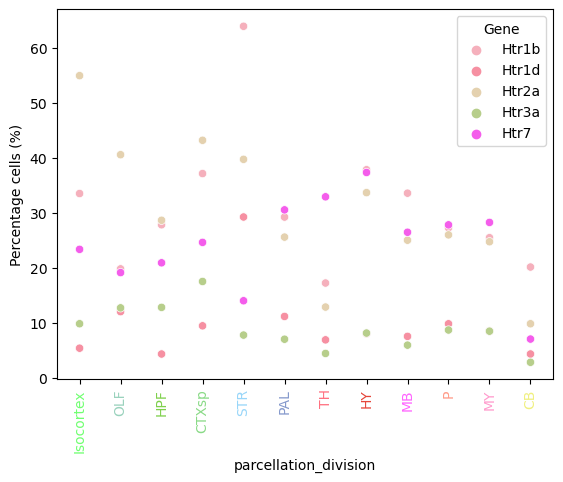

In [179]:
ax = sns.scatterplot(data=out, y="Percentage cells (%)", x ='parcellation_division', hue='Gene', palette=htr_cmap)

plt.draw()
for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_color(color_map[label.get_text()])

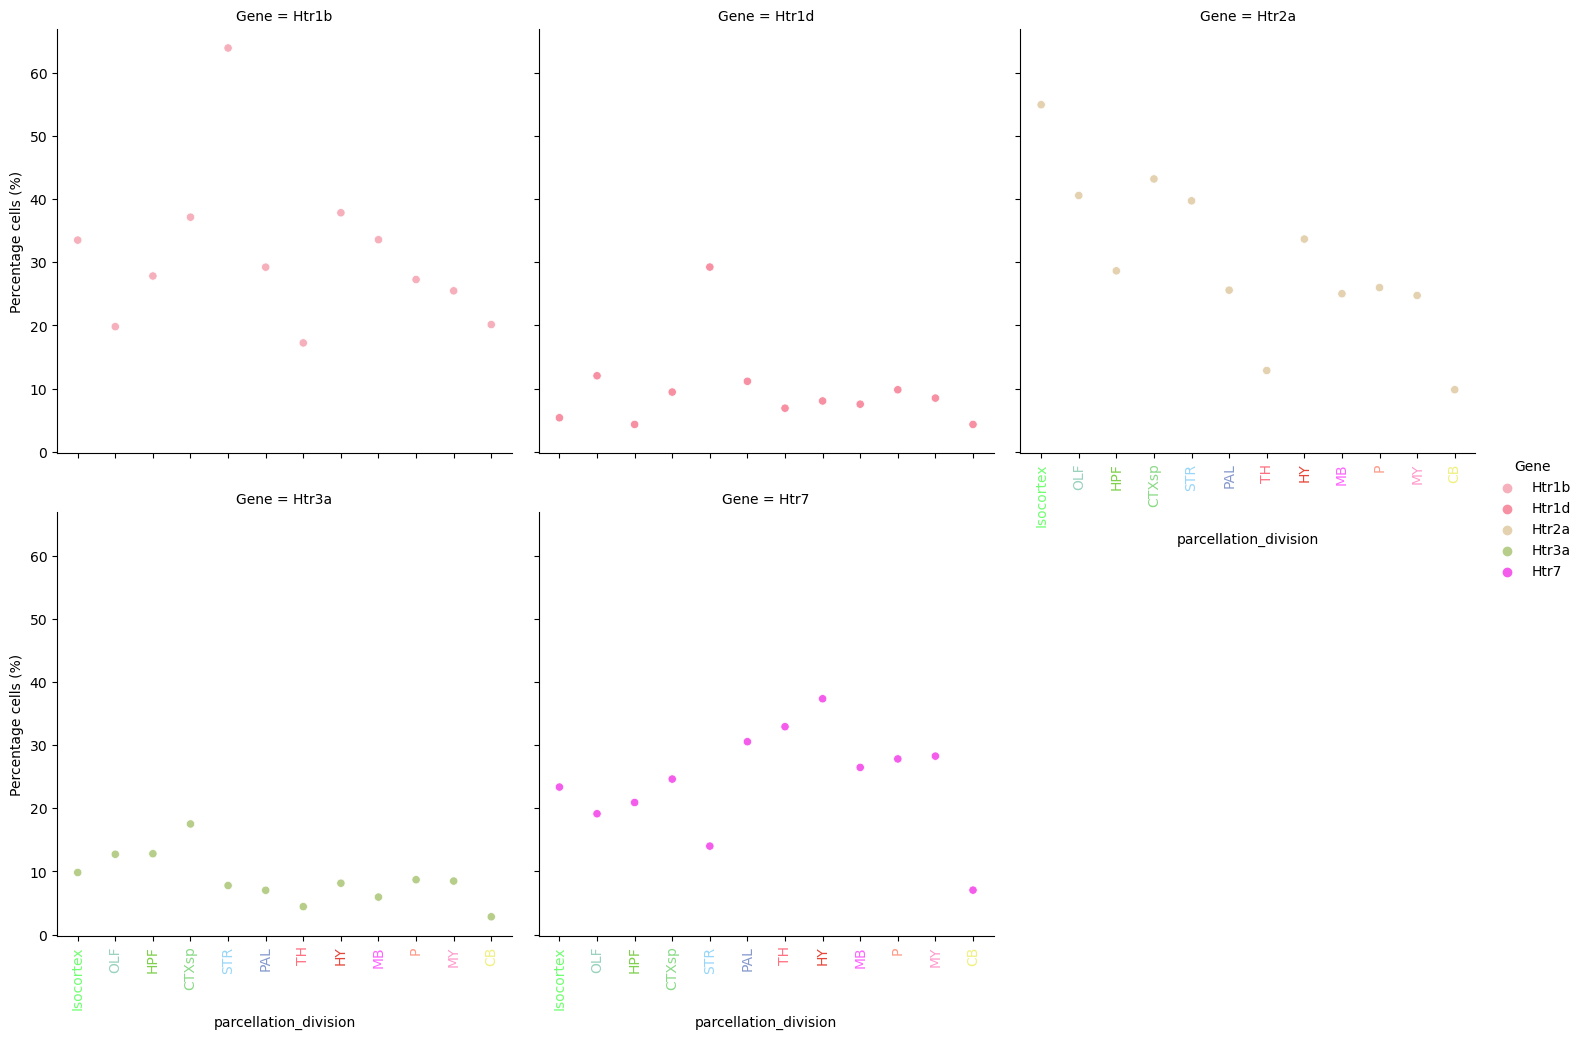

In [180]:
g = sns.relplot(kind="scatter", data=out, y="Percentage cells (%)", x ='parcellation_division', col='Gene',col_wrap=3,hue="Gene", palette=htr_cmap)

g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_color(color_map[label.get_text()])


In [112]:
out = []
for gene in exp.columns:
    _ = (joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby('parcellation_structure')[gene].sum().div(joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby(['parcellation_structure', 'parcellation_structure_color']).size())*100).rename("Percentage cells expressing (%)").reset_index().sort_values("parcellation_structure_color", ascending=False)
    _["Gene"] = gene
    out.append(_)

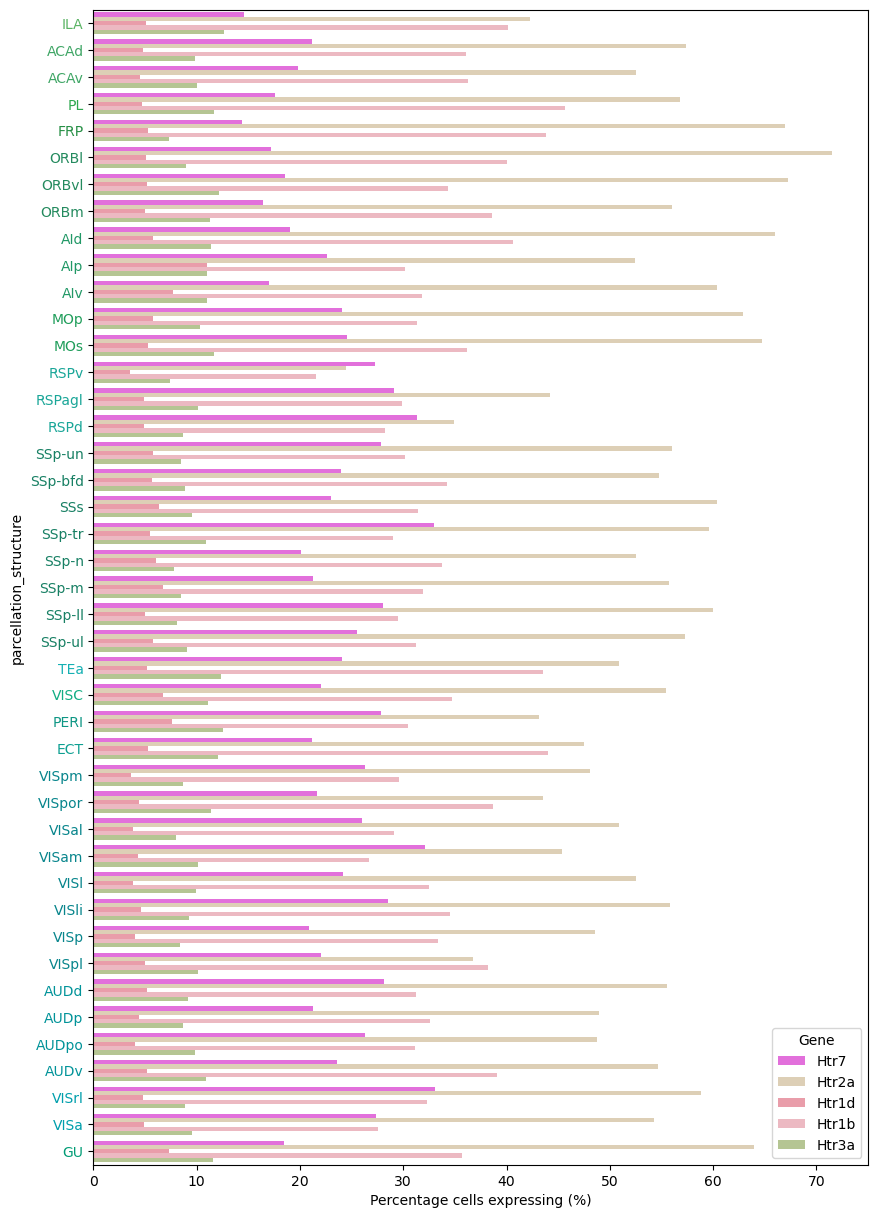

In [113]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(data=pd.concat(out, axis=0), y="parcellation_structure", x="Percentage cells expressing (%)", hue="Gene", palette=htr_cmap, ax=ax)

labels = [item.get_text() for item in ax.get_yticklabels()]


# Loop through each xtick label and set its color
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(color_map[labels[i]])  # Set color for each label from color_map


In [117]:
out = []
for gene in exp.columns:
    _ = (joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby(['parcellation_structure', 'parcellation_substructure'])[gene].sum().div(joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby(['parcellation_structure', 'parcellation_substructure']).size())*100).rename("Percentage cells expressing (%)").reset_index()
    _["Gene"] = gene
    out.append(_)

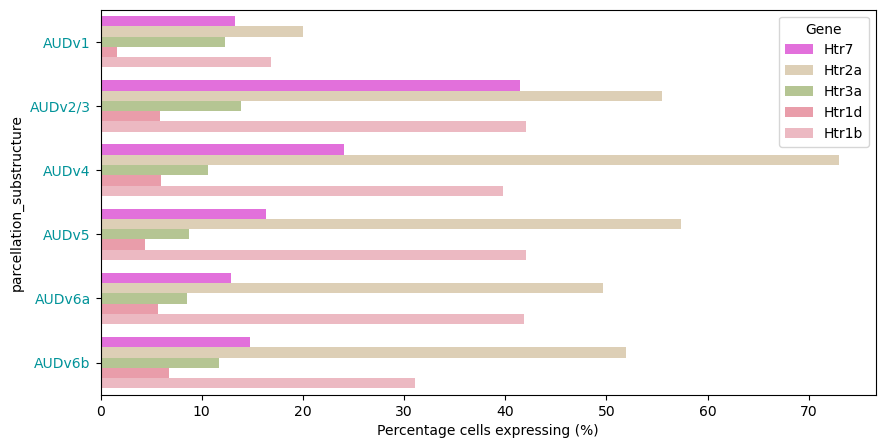

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
_ = pd.concat(out, axis=0).sort_values(["Gene"])

sns.barplot(data=_[_["parcellation_structure"]=="AUDv"].sort_values("parcellation_substructure"), y="parcellation_substructure", x="Percentage cells expressing (%)", hue="Gene", palette=htr_cmap, ax=ax)

labels = [item.get_text() for item in ax.get_yticklabels()]


# Loop through each xtick label and set its color
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(color_map[labels[i]])  # Set color for each label from color_map


In [123]:
out = pd.concat(out, axis=0)
# Assume df is your DataFrame
# Create a regular expression pattern to extract the layer information
pattern = r'(\d+[a-b]?/\d+[a-b]?|\d+[a-b]?)'

# Use str.extract to extract the layer information and create a new column called 'layer'
out['layer'] = out['parcellation_substructure'].str.extract(pattern)


<AxesSubplot:xlabel='Percentage cells expressing (%)', ylabel='layer'>

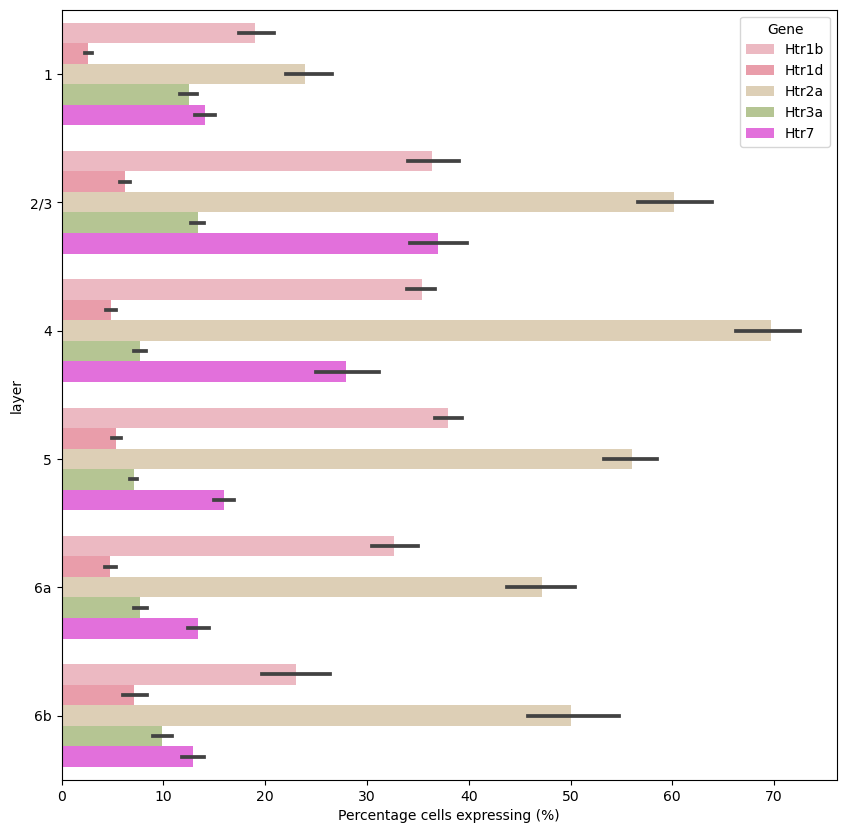

In [125]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=out.sort_values(["layer"], ascending=True),hue_order= htrgenes, y="layer", x="Percentage cells expressing (%)", hue="Gene", palette=htr_cmap, ax=ax)


In [156]:
(joined_bool[joined_bool['parcellation_division']=="HPF"].groupby('parcellation_structure')["Htr2a"].sum().div(
    joined_bool[joined_bool['parcellation_division']=="HPF"].groupby('parcellation_structure').size())).sort_values(ascending=False)

parcellation_structure
ENTl              0.414131
CA1               0.346459
CA2               0.335960
ProS              0.305374
ENTm              0.304108
PAR               0.301715
HATA              0.278897
CA3               0.278455
HPF-unassigned    0.257696
SUB               0.257536
APr               0.252297
PRE               0.209583
POST              0.209511
FC                0.197952
DG                0.143549
IG                0.132906
dtype: float64

In [101]:
joined[joined['parcellation_division']=="Isocortex"]

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color,Htr7,Htr2a,Htr1d,Htr1b,Htr3a
cell_label,,,,,,,,,,,,,,,,,,,,,
1017185048200840350,C57BL6J-638850.62,1392,0.670909,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.699135,4.907031,12.2,...,#FFFFFF,#BFDAE3,#70FF71,#248A5E,#248A5E,1.928214,2.245227,0.000000,0.0,1.521331
1018093345102490830,C57BL6J-638850.45,1392,0.594774,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.011986,3.389138,8.2,...,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064,0.000000,0.000000,0.898689,0.0,3.134112
1019171907101310517-1,C57BL6J-638850.43,1396,0.549844,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.651665,3.587839,7.8,...,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064,0.932501,0.000000,0.000000,0.0,1.494243
1018093344100620662,C57BL6J-638850.35,1258,0.507612,C57BL6J-638850,C57BL6J-638850,wt/wt,M,9.652782,4.453068,6.2,...,#FFFFFF,#BFDAE3,#70FF71,#019399,#019399,0.000000,0.000000,1.175199,0.0,0.000000
1104095349100410052,C57BL6J-638850.39,1392,0.600921,C57BL6J-638850,C57BL6J-638850,wt/wt,M,0.787763,6.456709,7.0,...,#FFFFFF,#BFDAE3,#70FF71,#11AD83,#11AD83,1.459729,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019171910102600563,C57BL6J-638850.28,5254,0.595210,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.883934,4.426862,4.6,...,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C,0.000000,0.000000,0.000000,0.0,0.658885
1018093344100380167-3,C57BL6J-638850.47,5252,0.574988,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.560003,4.669243,8.8,...,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064,0.000000,0.000000,0.000000,0.0,0.000000
1017165415100930567,C57BL6J-638850.57,5254,0.620546,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.032556,3.695696,11.0,...,#FFFFFF,#BFDAE3,#70FF71,#40A666,#40A666,0.000000,0.851338,0.000000,0.0,0.000000


The MERFISH data allows us to visualize these spatial pattern in anatomical context. We can aggregate Tac2 expression by brain section so that we can find 4 sections where the enriched expression is located. We then visualize cells in those section by Tac2 expression, neurotransmitter identity, cell type classes and subclasses. 

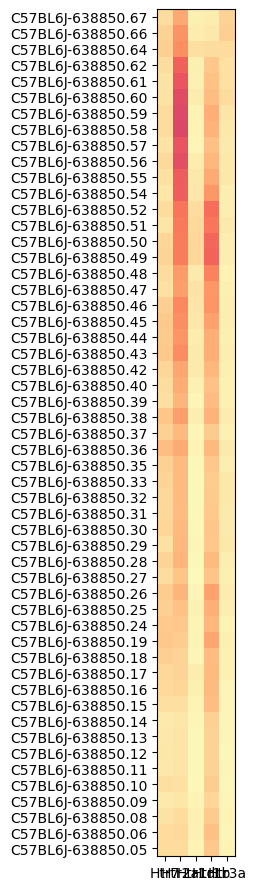

In [77]:
agg = aggregate_by_metadata( joined, exgenes, 'brain_section_label', False )
agg = agg.loc[list(reversed(list(agg.index)))]
plot_heatmap(agg,1,11, vmax=3)

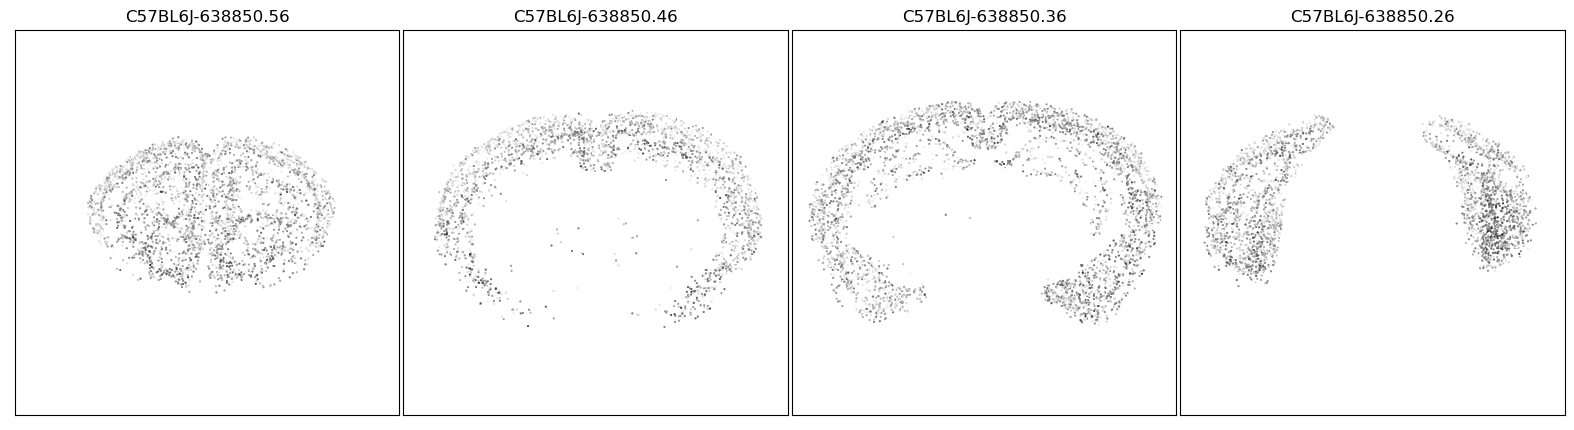

In [91]:
blist = ['C57BL6J-638850.56','C57BL6J-638850.46','C57BL6J-638850.36','C57BL6J-638850.26']
fig, ax = plot_sections( joined[joined["class"].isin(['07 CTX-MGE GABA',  '06 CTX-CGE GABA'])], 'Htr2a', blist, cmap=plt.cm.Greys, vmin=0,vmax=5)

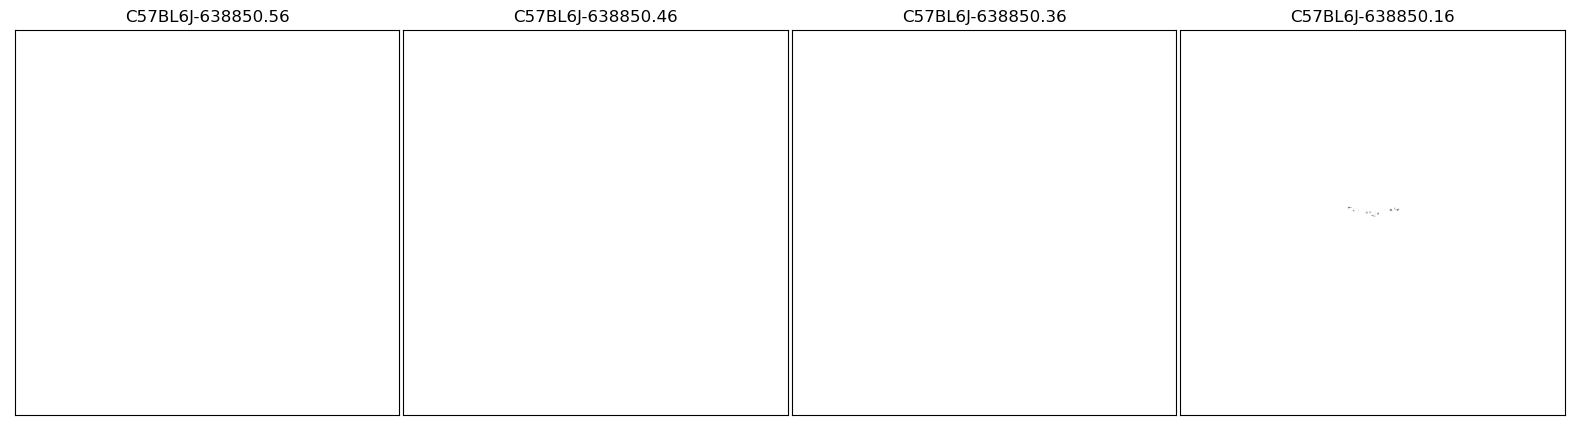

In [106]:
blist = ['C57BL6J-638850.56','C57BL6J-638850.46','C57BL6J-638850.36','C57BL6J-638850.26']
fig, ax = plot_sections( joined[joined['parcellation_division']=="V4"], 'Htr2a', blist, cmap=plt.cm.Greys, vmin=0,vmax=5)

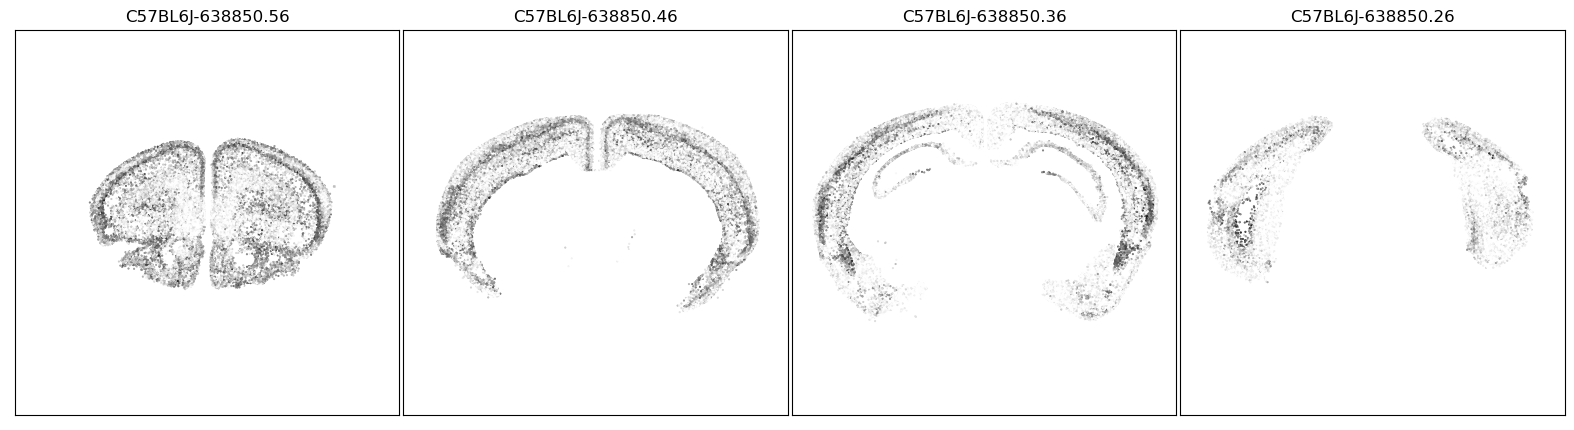

In [79]:

fig, ax = plot_sections( joined[joined["class"].isin([ '02 NP-CT-L6b Glut',  '01 IT-ET Glut'])], 'Htr2a', blist, cmap=plt.cm.Greys, vmin=0,vmax=5)

In [ ]:
fig, axs = plt.subplots(1,len(blist))
fig_width = 20
fig_height = 5


for n, slice in enumerate(blist):
    pred = (cell['brain_section_label'] == slice )
    section = cell[pred]
    plot_section_CCF(xx=section['x_reconstructed'], yy=section['y_reconstructed'], 
                               cc=section['parcellation_structure_color'], alpha=.2, fig=fig, ax=axs[n])
plt.subplots_adjust(wspace=0.01, hspace=0.01)
fig.set_size_inches(fig_width, fig_height)

In [ ]:
fig, ax = plot_sections( joined, 'neurotransmitter_color', blist, cmap=None)

In [ ]:
fig, ax = plot_sections( joined, 'class_color', blist, cmap=None)

In [ ]:
fig, ax = plot_sections( joined, 'subclass_color', blist, cmap=None)

We can use the Tac2 aggregate by subclass table above and pick out the top 10 most enriched subclasses and plot only them on the same set of brain sections and observed that this set of subclasses is able recapitulate the expression pattern of Tac2.

In [ ]:
top_all[top_all.index.str.contains('Sst')].index

In [ ]:
top_all

In [ ]:
def plot_sections( df, feature, blist, cmap=None, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist) :
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x_reconstructed']
        yy = filtered['y_reconstructed']
        vv = filtered[feature]
        
        if cmap is not None :
            ax[idx].scatter(xx,yy,s=1.0,c=vv,marker='.',cmap=cmap)
        else :
            ax[idx].scatter(xx,yy,s=1.0,color=vv,marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0,11)
        ax[idx].set_ylim(11,0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s" % (bsl) )
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax
    

In [ ]:
subclass_list = top_all[top_all.index.str.contains('Sst')].index


blist = ['C57BL6J-638850.56','C57BL6J-638850.46','C57BL6J-638850.36','C57BL6J-638850.26']
pred = [x in subclass_list for x in joined[level]]
filtered = joined[pred]
fig, ax = plot_sections( filtered, 'supertype_color', blist, cmap=None)

In [ ]:
subclass_list = top_all[top_all.index.str.contains('Pv')].index


blist = ['C57BL6J-638850.56','C57BL6J-638850.46','C57BL6J-638850.36','C57BL6J-638850.26']
pred = [x in subclass_list for x in joined[level]]
filtered = joined[pred]
fig, ax = plot_sections( filtered, 'supertype_color', blist, cmap=None)

In [ ]:
agg = aggregate_by_metadata( filtered, exgenes, 'brain_section_label', False )
agg = agg.loc[list(reversed(list(agg.index)))]
plot_heatmap(agg,1,11, vmax=5)

In [ ]:
brain_section = 'C57BL6J-638850.26'
pred = (filtered['brain_section_label'] == brain_section )
section_target = filtered[pred]


In [ ]:

pred = (cell['brain_section_label'] == brain_section )
section = cell[pred]
print(len(section))

In [ ]:
fig, ax = plot_section_CCF(xx=section['x_reconstructed'], yy=section['y_reconstructed'], 
                               cc=section['parcellation_structure_color'], alpha=.2)

fig, ax = plot_section_CCF(xx=section_target['x_reconstructed'], yy=section_target['y_reconstructed'], 
                               cc="k", fig=fig, ax=ax, s=10)

res = ax.set_title("Structure - Reconstructed Coordinates")